In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load and preprocess the dataset
df = pd.read_csv('diabetes_data.csv')
df.drop(['PatientID', 'SocioeconomicStatus', 'EducationLevel', 'DoctorInCharge'], axis=1, inplace=True)
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']


In [3]:
# Scale data
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# Apply SparsePCA
spca = SparsePCA(n_components=35, alpha=1.0, random_state=42)
X_spca = spca.fit_transform(X_scaled)

In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_spca, y, test_size=0.2, random_state=42)


In [6]:
# Initialize models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "SVC": SVC(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}


In [7]:
# Evaluate initial models
initial_results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    initial_results.append([name, acc])


[LightGBM] [Info] Number of positive: 609, number of negative: 894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4858
[LightGBM] [Info] Number of data points in the train set: 1503, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405190 -> initscore=-0.383888
[LightGBM] [Info] Start training from score -0.383888


In [ ]:
# Display initial results
print("\nInitial Model Accuracies:")
print(tabulate(initial_results, headers=["Model", "Accuracy"], tablefmt="grid"))





Initial Model Accuracies:
+---------------+------------+
| Model         |   Accuracy |
+===============+============+
| Random Forest |   0.914894 |
+---------------+------------+
| XGBoost       |   0.922872 |
+---------------+------------+
| LightGBM      |   0.922872 |
+---------------+------------+
| CatBoost      |   0.93883  |
+---------------+------------+
| AdaBoost      |   0.93617  |
+---------------+------------+
| SVC           |   0.835106 |
+---------------+------------+
| Decision Tree |   0.845745 |
+---------------+------------+


In [ ]:
# AdaBoost
def tune_adaboost(trial):
    model = AdaBoostClassifier(
        n_estimators=trial.suggest_int('n_estimators', 50, 200),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        random_state=42
    )
    return cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
# LightGBM
def tune_lgbm(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
        'n_jobs': -1  # Use all available cores
    }
    model = LGBMClassifier(**params)
    return cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()

# CatBoost
def tune_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': 0,
        'random_seed': 42
    }
    model = CatBoostClassifier(**params)
    return cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()




In [ ]:

# AdaBoost tuning
study_ada = optuna.create_study(direction='maximize')
study_ada.optimize(tune_adaboost, n_trials=40)

# LightGBM tuning
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(tune_lgbm, n_trials=40)

# CatBoost tuning
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(tune_catboost, n_trials=40)


[I 2025-07-04 15:48:02,700] A new study created in memory with name: no-name-803c1adc-fda1-4502-9268-17e20e017a7b
[I 2025-07-04 15:48:04,267] Trial 0 finished with value: 0.9174983366600133 and parameters: {'n_estimators': 183, 'learning_rate': 0.08770645631874607}. Best is trial 0 with value: 0.9174983366600133.
[I 2025-07-04 15:48:05,439] Trial 1 finished with value: 0.899534264803726 and parameters: {'n_estimators': 139, 'learning_rate': 0.01806232791966184}. Best is trial 0 with value: 0.9174983366600133.
[I 2025-07-04 15:48:06,697] Trial 2 finished with value: 0.9214903526280772 and parameters: {'n_estimators': 148, 'learning_rate': 0.1699897965393051}. Best is trial 2 with value: 0.9214903526280772.
[I 2025-07-04 15:48:07,722] Trial 3 finished with value: 0.9194943446440452 and parameters: {'n_estimators': 120, 'learning_rate': 0.15285704693149257}. Best is trial 2 with value: 0.9214903526280772.
[I 2025-07-04 15:48:08,656] Trial 4 finished with value: 0.9234863606121091 and para

[LightGBM] [Info] Number of positive: 406, number of negative: 596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4858
[LightGBM] [Info] Number of data points in the train set: 1002, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405190 -> initscore=-0.383888
[LightGBM] [Info] Start training from score -0.383888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-07-04 15:48:50,111] Trial 0 finished with value: 0.9234863606121091 and parameters: {'num_leaves': 110, 'learning_rate': 0.23333895897507076, 'n_estimators': 119, 'subsample': 0.5742598136161636, 'colsample_bytree': 0.506914019141159}. Best is trial 0 with value: 0.9234863606121091.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-04 15:48:50,754] Trial 1 finished with value: 0.918829008649368 and parameters: {'num_leaves': 90, 'learning_rate': 0.02509280043206955, 'n_estimators': 154, 'subsample': 0.8779727259746843, 'colsample_bytree': 0.5322993521213435}. Best is trial 0 with value: 0.9234863606121091.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-04 15:48:51,729] Trial 2 finished with value: 0.9248170326014638 and parameters: {'num_leaves': 123, 'learning_rate': 0.05635129795166776, 'n_estimators': 200, 'subsample': 0.8806128184237293, 'colsample_bytree': 0.9905103643101508}. Best is trial 2 with value: 0.9248170326014638.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 406, number of negative: 596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4858
[LightGBM] [Info] Number of data points in the train set: 1002, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405190 -> initscore=-0.383888
[LightGBM] [Info] Start training from score -0.383888
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-07-04 15:48:52,246] Trial 3 finished with value: 0.9194943446440452 and parameters: {'num_leaves': 42, 'learning_rate': 0.05904513549020373, 'n_estimators': 92, 'subsample': 0.8159372258519836, 'colsample_bytree': 0.7503451389520512}. Best is trial 2 with value: 0.9248170326014638.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-04 15:48:52,731] Trial 4 finished with value: 0.9168330006653361 and parameters: {'num_leaves': 38, 'learning_rate': 0.2676094728167769, 'n_estimators': 181, 'subsample': 0.8399239185656021, 'colsample_bytree': 0.565191045219283}. Best is trial 2 with value: 0.9248170326014638.


[LightGBM] [Info] Number of positive: 406, number of negative: 596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4858
[LightGBM] [Info] Number of data points in the train set: 1002, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405190 -> initscore=-0.383888
[LightGBM] [Info] Start training from score -0.383888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-07-04 15:48:53,370] Trial 5 finished with value: 0.9194943446440452 and parameters: {'num_leaves': 78, 'learning_rate': 0.019503977657384774, 'n_estimators': 159, 'subsample': 0.6199481540413156, 'colsample_bytree': 0.8491796104215907}. Best is trial 2 with value: 0.9248170326014638.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-04 15:48:53,834] Trial 6 finished with value: 0.9108449767132402 and parameters: {'num_leaves': 97, 'learning_rate': 0.013009163164493416, 'n_estimators': 108, 'subsample': 0.6763183997322719, 'colsample_bytree': 0.5916588437648824}. Best is trial 2 with value: 0.9248170326014638.


[LightGBM] [Info] Number of positive: 406, number of negative: 596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4858
[LightGBM] [Info] Number of data points in the train set: 1002, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405190 -> initscore=-0.383888
[LightGBM] [Info] Start training from score -0.383888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-07-04 15:48:54,456] Trial 7 finished with value: 0.9301397205588823 and parameters: {'num_leaves': 119, 'learning_rate': 0.15656028329271912, 'n_estimators': 137, 'subsample': 0.7682602311074818, 'colsample_bytree': 0.9669455573297265}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Info] Number of positive: 406, number of negative: 596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4858
[LightGBM] [Info] Number of data points in the train set: 1002, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405190 -> initscore=-0.383888
[LightGBM] [Info] Start training from score -0.383888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-07-04 15:48:54,826] Trial 8 finished with value: 0.9214903526280772 and parameters: {'num_leaves': 117, 'learning_rate': 0.05321568991958014, 'n_estimators': 87, 'subsample': 0.8463922312002184, 'colsample_bytree': 0.6571722163963386}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-04 15:48:55,562] Trial 9 finished with value: 0.9135063206919494 and parameters: {'num_leaves': 138, 'learning_rate': 0.01198651728484515, 'n_estimators': 177, 'subsample': 0.6494144768943311, 'colsample_bytree': 0.520936167795933}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 406, number of negative: 596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4858
[LightGBM] [Info] Number of data points in the train set: 1002, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405190 -> initscore=-0.383888
[LightGBM] [Info] Start training from sc

[I 2025-07-04 15:48:55,880] Trial 10 finished with value: 0.9261477045908184 and parameters: {'num_leaves': 67, 'learning_rate': 0.134372467891161, 'n_estimators': 69, 'subsample': 0.9845880943796794, 'colsample_bytree': 0.9881076656492257}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-04 15:48:56,147] Trial 11 finished with value: 0.9214903526280772 and parameters: {'num_leaves': 64, 'learning_rate': 0.13535130313478683, 'n_estimators': 52, 'subsample': 0.9694075557489072, 'colsample_bytree': 0.9849986155773366}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Info] Number of positive: 406, number of negative: 596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4858
[LightGBM] [Info] Number of data points in the train set: 1002, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405190 -> initscore=-0.383888
[LightGBM] [Info] Start training from score -0.383888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-07-04 15:48:56,779] Trial 12 finished with value: 0.9248170326014638 and parameters: {'num_leaves': 147, 'learning_rate': 0.14735642808883495, 'n_estimators': 143, 'subsample': 0.9965526110176877, 'colsample_bytree': 0.8945053048137198}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Info] Number of positive: 406, number of negative: 596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4858
[LightGBM] [Info] Number of data points in the train set: 1002, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405190 -> initscore=-0.383888
[LightGBM] [Info] Start training from score -0.383888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-07-04 15:48:57,080] Trial 13 finished with value: 0.9194943446440452 and parameters: {'num_leaves': 60, 'learning_rate': 0.11287221971511797, 'n_estimators': 55, 'subsample': 0.7335437510704782, 'colsample_bytree': 0.9024713599565737}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-04 15:48:57,470] Trial 14 finished with value: 0.9248170326014638 and parameters: {'num_leaves': 25, 'learning_rate': 0.09867306840919884, 'n_estimators': 130, 'subsample': 0.5302038157241812, 'colsample_bytree': 0.8057641660237933}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Info] Number of positive: 406, number of negative: 596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4858
[LightGBM] [Info] Number of data points in the train set: 1002, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405190 -> initscore=-0.383888
[LightGBM] [Info] Start training from score -0.383888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-07-04 15:48:57,842] Trial 15 finished with value: 0.9261477045908184 and parameters: {'num_leaves': 68, 'learning_rate': 0.1873651648390816, 'n_estimators': 80, 'subsample': 0.7625715340323653, 'colsample_bytree': 0.94018166140425}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-04 15:48:58,305] Trial 16 finished with value: 0.9214903526280772 and parameters: {'num_leaves': 98, 'learning_rate': 0.0817280929267743, 'n_estimators': 105, 'subsample': 0.926042362216219, 'colsample_bytree': 0.8269222444171678}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 406, number of negative: 596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4858
[LightGBM] [Info] Number of data points in the train set: 1002, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405190 -> initscore=-0.383888
[LightGBM] [Info] Start training from sc

[I 2025-07-04 15:48:58,606] Trial 17 finished with value: 0.9141716566866268 and parameters: {'num_leaves': 79, 'learning_rate': 0.034424092283854305, 'n_estimators': 68, 'subsample': 0.7557184198948801, 'colsample_bytree': 0.7039413674350996}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-04 15:48:59,184] Trial 18 finished with value: 0.9288090485695276 and parameters: {'num_leaves': 131, 'learning_rate': 0.17266364939735868, 'n_estimators': 133, 'subsample': 0.9325586570156501, 'colsample_bytree': 0.9350311109039036}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-04 15:48:59,770] Trial 19 finished with value: 0.9234863606121091 and parameters: {'num_leaves': 131, 'learning_rate': 0.1943955128331561, 'n_estimators': 134, 'subsample': 0.7200098152685662, 'colsample_bytree': 0.9177213512958275}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Info] Number of positive: 406, number of negative: 596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4858
[LightGBM] [Info] Number of data points in the train set: 1002, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405190 -> initscore=-0.383888
[LightGBM] [Info] Start training from score -0.383888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-07-04 15:49:00,263] Trial 20 finished with value: 0.9234863606121091 and parameters: {'num_leaves': 150, 'learning_rate': 0.28008181762824946, 'n_estimators': 157, 'subsample': 0.9276472282269694, 'colsample_bytree': 0.762897512972863}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-04 15:49:00,811] Trial 21 finished with value: 0.9268130405854956 and parameters: {'num_leaves': 112, 'learning_rate': 0.1526828845789498, 'n_estimators': 111, 'subsample': 0.9450434284322277, 'colsample_bytree': 0.95762300881291}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Info] Number of positive: 406, number of negative: 596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4858
[LightGBM] [Info] Number of data points in the train set: 1002, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405190 -> initscore=-0.383888
[LightGBM] [Info] Start training from score -0.383888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-07-04 15:49:01,352] Trial 22 finished with value: 0.9221556886227544 and parameters: {'num_leaves': 107, 'learning_rate': 0.07799288780415752, 'n_estimators': 118, 'subsample': 0.9222365720065324, 'colsample_bytree': 0.8672837078713548}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-04 15:49:01,967] Trial 23 finished with value: 0.9234863606121091 and parameters: {'num_leaves': 128, 'learning_rate': 0.1637382014837852, 'n_estimators': 143, 'subsample': 0.811162858679547, 'colsample_bytree': 0.9421824782095602}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-04 15:49:02,435] Trial 24 finished with value: 0.9234863606121091 and parameters: {'num_leaves': 111, 'learning_rate': 0.20452499644743655, 'n_estimators': 102, 'subsample': 0.9494265078796891, 'colsample_bytree': 0.9580235230128308}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Info] Number of positive: 406, number of negative: 596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4858
[LightGBM] [Info] Number of data points in the train set: 1002, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405190 -> initscore=-0.383888
[LightGBM] [Info] Start training from score -0.383888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-07-04 15:49:03,069] Trial 25 finished with value: 0.9254823685961412 and parameters: {'num_leaves': 138, 'learning_rate': 0.10952206339258917, 'n_estimators': 119, 'subsample': 0.8950150861170781, 'colsample_bytree': 0.8784297566406569}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Info] Number of positive: 406, number of negative: 596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4858
[LightGBM] [Info] Number of data points in the train set: 1002, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405190 -> initscore=-0.383888
[LightGBM] [Info] Start training from score -0.383888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-07-04 15:49:03,736] Trial 26 finished with value: 0.9241516966067863 and parameters: {'num_leaves': 120, 'learning_rate': 0.09755563444944075, 'n_estimators': 144, 'subsample': 0.7928907410679936, 'colsample_bytree': 0.7930035193506844}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Info] Number of positive: 406, number of negative: 596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4858
[LightGBM] [Info] Number of data points in the train set: 1002, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405190 -> initscore=-0.383888
[LightGBM] [Info] Start training from score -0.383888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-07-04 15:49:04,538] Trial 27 finished with value: 0.9248170326014638 and parameters: {'num_leaves': 101, 'learning_rate': 0.07668389734407081, 'n_estimators': 174, 'subsample': 0.6979358603984973, 'colsample_bytree': 0.9348447937128772}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-04 15:49:04,978] Trial 28 finished with value: 0.9241516966067865 and parameters: {'num_leaves': 137, 'learning_rate': 0.2896111202936636, 'n_estimators': 130, 'subsample': 0.8507630889093457, 'colsample_bytree': 0.9640864848361633}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Info] Number of positive: 406, number of negative: 596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4858
[LightGBM] [Info] Number of data points in the train set: 1002, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405190 -> initscore=-0.383888
[LightGBM] [Info] Start training from score -0.383888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-07-04 15:49:05,467] Trial 29 finished with value: 0.9274783765801731 and parameters: {'num_leaves': 111, 'learning_rate': 0.21989824433219562, 'n_estimators': 118, 'subsample': 0.5882159332239143, 'colsample_bytree': 0.9993217682985724}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-04 15:49:05,999] Trial 30 finished with value: 0.9281437125748503 and parameters: {'num_leaves': 126, 'learning_rate': 0.21369438924068995, 'n_estimators': 125, 'subsample': 0.5028559436047075, 'colsample_bytree': 0.9958386456943087}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Info] Number of positive: 406, number of negative: 596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4858
[LightGBM] [Info] Number of data points in the train set: 1002, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405190 -> initscore=-0.383888
[LightGBM] [Info] Start training from score -0.383888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-07-04 15:49:06,555] Trial 31 finished with value: 0.9241516966067863 and parameters: {'num_leaves': 124, 'learning_rate': 0.22755563259331665, 'n_estimators': 120, 'subsample': 0.5051658773881031, 'colsample_bytree': 0.9786695161460675}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-04 15:49:07,356] Trial 32 finished with value: 0.9248170326014638 and parameters: {'num_leaves': 133, 'learning_rate': 0.2384812697786772, 'n_estimators': 135, 'subsample': 0.5733144327758054, 'colsample_bytree': 0.917456502487287}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-04 15:49:08,377] Trial 33 finished with value: 0.925482368596141 and parameters: {'num_leaves': 116, 'learning_rate': 0.17891118153167943, 'n_estimators': 152, 'subsample': 0.5778690505791888, 'colsample_bytree': 0.9961386658793807}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 406, number of negative: 596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Tot

[I 2025-07-04 15:49:09,231] Trial 34 finished with value: 0.925482368596141 and parameters: {'num_leaves': 89, 'learning_rate': 0.2319823679133529, 'n_estimators': 96, 'subsample': 0.5589412683907339, 'colsample_bytree': 0.9973446088996826}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-04 15:49:10,263] Trial 35 finished with value: 0.9221556886227544 and parameters: {'num_leaves': 104, 'learning_rate': 0.1271542396181016, 'n_estimators': 125, 'subsample': 0.609170720621683, 'colsample_bytree': 0.8505992588686849}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 406, number of negative: 596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4858
[LightGBM] [Info] Number of data points in the train set: 1002, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405190 -> initscore=-0.383888
[LightGBM] [Info] Start training from score -0.383888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-07-04 15:49:11,124] Trial 36 finished with value: 0.9234863606121091 and parameters: {'num_leaves': 144, 'learning_rate': 0.29636052944376895, 'n_estimators': 165, 'subsample': 0.5059114555720302, 'colsample_bytree': 0.9287868934756407}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-04 15:49:12,156] Trial 37 finished with value: 0.9214903526280772 and parameters: {'num_leaves': 128, 'learning_rate': 0.046933395549264685, 'n_estimators': 113, 'subsample': 0.6218363833310658, 'colsample_bytree': 0.8919712327198747}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-04 15:49:13,337] Trial 38 finished with value: 0.9281437125748503 and parameters: {'num_leaves': 92, 'learning_rate': 0.16675988739160605, 'n_estimators': 189, 'subsample': 0.5534732113587958, 'colsample_bytree': 0.9666836543509425}. Best is trial 7 with value: 0.9301397205588823.


[LightGBM] [Info] Number of positive: 406, number of negative: 596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4858
[LightGBM] [Info] Number of data points in the train set: 1002, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405190 -> initscore=-0.383888
[LightGBM] [Info] Start training from score -0.383888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-07-04 15:49:14,724] Trial 39 finished with value: 0.9181636726546906 and parameters: {'num_leaves': 90, 'learning_rate': 0.16796919861018803, 'n_estimators': 198, 'subsample': 0.5240580671603162, 'colsample_bytree': 0.6276616536071431}. Best is trial 7 with value: 0.9301397205588823.
[I 2025-07-04 15:49:14,725] A new study created in memory with name: no-name-48d9c197-c1d8-444f-b05f-3fb508d0eb55


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-04 15:49:15,872] Trial 0 finished with value: 0.9181636726546906 and parameters: {'iterations': 130, 'learning_rate': 0.03910172995326879, 'depth': 7, 'l2_leaf_reg': 0.14708117162595785, 'border_count': 143}. Best is trial 0 with value: 0.9181636726546906.
[I 2025-07-04 15:49:16,592] Trial 1 finished with value: 0.9228210246174319 and parameters: {'iterations': 74, 'learning_rate': 0.09720569053841992, 'depth': 7, 'l2_leaf_reg': 0.020781989081310192, 'border_count': 175}. Best is trial 1 with value: 0.9228210246174319.
[I 2025-07-04 15:49:16,987] Trial 2 finished with value: 0.9174983366600133 and parameters: {'iterations': 58, 'learning_rate': 0.01658442732737976, 'depth': 5, 'l2_leaf_reg': 0.005960843923918871, 'border_count': 241}. Best is trial 1 with value: 0.9228210246174319.
[I 2025-07-04 15:49:17,924] Trial 3 finished with value: 0.9168330006653361 and parameters: {'iterations': 83, 'learning_rate': 0.023470886333304807, 'depth': 8, 'l2_leaf_reg': 3.347037267262522, 

In [ ]:

# Get best parameters
ada_best = study_ada.best_params
lgbm_best = study_lgbm.best_params
cat_best = study_cat.best_params

# Create tuned models
tuned_models = {
    "Tuned AdaBoost": AdaBoostClassifier(**ada_best, random_state=42),
    "Tuned LightGBM": LGBMClassifier(**lgbm_best, random_state=42),
    "Tuned CatBoost": CatBoostClassifier(**cat_best, random_state=42, verbose=0)
}

# Evaluate tuned models
tuned_results = []
for name, model in tuned_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    tuned_results.append([name, acc])

# Display tuned results
print("\nTuned Model Accuracies:")
print(tabulate(tuned_results, headers=["Model", "Accuracy"], tablefmt="grid"))


[LightGBM] [Info] Number of positive: 609, number of negative: 894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4858
[LightGBM] [Info] Number of data points in the train set: 1503, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405190 -> initscore=-0.383888
[LightGBM] [Info] Start training from score -0.383888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [ ]:

# Identify top 2 models from initial and tuned results
all_results = initial_results + tuned_results
all_results_sorted = sorted(all_results, key=lambda x: x[1], reverse=True)
top_models = all_results_sorted[:2]

print("\nTop 2 Models for Stacking:")
print(tabulate(top_models, headers=["Model", "Accuracy"], tablefmt="grid"))

# Get the actual model objects for the top 2 models
top_model_objects = []
for name, acc in top_models:
    if name in models:
        top_model_objects.append((name, models[name]))
    elif name in tuned_models:
        top_model_objects.append((name, tuned_models[name]))

# Create stacking classifier
stacking_model = StackingClassifier(
    estimators=top_model_objects,
    final_estimator=LogisticRegression(random_state=42),
    cv=3
)



Top 2 Models for Stacking:
+----------+------------+
| Model    |   Accuracy |
+==========+============+
| CatBoost |    0.93883 |
+----------+------------+
| AdaBoost |    0.93617 |
+----------+------------+


In [13]:
# Train and evaluate stacking model
stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)
stack_acc = accuracy_score(y_test, y_pred_stack)

In [ ]:

# Combine all results
final_results = initial_results + tuned_results + [["Stacked Model", stack_acc]]

print("\nFinal Model Accuracies:")
print(tabulate(final_results, headers=["Model", "Accuracy"], tablefmt="grid"))


Final Model Accuracies:
+----------------+------------+
| Model          |   Accuracy |
+================+============+
| Random Forest  |   0.914894 |
+----------------+------------+
| XGBoost        |   0.922872 |
+----------------+------------+
| LightGBM       |   0.922872 |
+----------------+------------+
| CatBoost       |   0.93883  |
+----------------+------------+
| AdaBoost       |   0.93617  |
+----------------+------------+
| SVC            |   0.835106 |
+----------------+------------+
| Decision Tree  |   0.845745 |
+----------------+------------+
| Tuned AdaBoost |   0.933511 |
+----------------+------------+
| Tuned LightGBM |   0.922872 |
+----------------+------------+
| Tuned CatBoost |   0.933511 |
+----------------+------------+
| Stacked Model  |   0.946809 |
+----------------+------------+


In [ ]:
from sklearn.metrics import accuracy_score, f1_score


def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return [name, acc, f1]


final_metrics = []
for name, model in models.items():
    final_metrics.append(evaluate_model(name, model, X_test, y_test))


for name, model in tuned_models.items():
    final_metrics.append(evaluate_model(name, model, X_test, y_test))


final_metrics.append(evaluate_model("Stacked Model", stacking_model, X_test, y_test))


metrics_df = pd.DataFrame(final_metrics, columns=["Model", "Accuracy", "F1 Score"])
metrics_df_sorted = metrics_df.sort_values(by="F1 Score", ascending=False)


from tabulate import tabulate
print("\nFinal Evaluation (Accuracy and F1 Score):")
print(tabulate(metrics_df_sorted, headers="keys", tablefmt="grid", showindex=False))



Final Evaluation (Accuracy and F1 Score):
+----------------+------------+------------+
| Model          |   Accuracy |   F1 Score |
+================+============+============+
| Stacked Model  |   0.946809 |   0.928571 |
+----------------+------------+------------+
| CatBoost       |   0.93883  |   0.916364 |
+----------------+------------+------------+
| AdaBoost       |   0.93617  |   0.915493 |
+----------------+------------+------------+
| Tuned AdaBoost |   0.933511 |   0.912281 |
+----------------+------------+------------+
| Tuned CatBoost |   0.933511 |   0.910394 |
+----------------+------------+------------+
| XGBoost        |   0.922872 |   0.893773 |
+----------------+------------+------------+
| Tuned LightGBM |   0.922872 |   0.893773 |
+----------------+------------+------------+
| LightGBM       |   0.922872 |   0.892989 |
+----------------+------------+------------+
| Random Forest  |   0.914894 |   0.879699 |
+----------------+------------+------------+
| Decision T

In [16]:
from sklearn.svm import SVC
svc_model = SVC(probability=True)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    return [name, precision, recall, f1, acc]


final_metrics = []
for name, model in models.items():
    final_metrics.append(evaluate_model(name, model, X_test, y_test))

for name, model in tuned_models.items():
    final_metrics.append(evaluate_model(name, model, X_test, y_test))

final_metrics.append(evaluate_model("Stacked Model", stacking_model, X_test, y_test))


metrics_df = pd.DataFrame(final_metrics, columns=["Model", "Precision", "Recall", "F1 Score", "Accuracy"])
metrics_df_sorted = metrics_df.sort_values(by="F1 Score", ascending=False)


from tabulate import tabulate
print("\nFinal Evaluation Metrics:")
print(tabulate(metrics_df_sorted, headers="keys", tablefmt="grid", showindex=False))



Final Evaluation Metrics:
+----------------+-------------+----------+------------+------------+
| Model          |   Precision |   Recall |   F1 Score |   Accuracy |
+================+=============+==========+============+============+
| Stacked Model  |    0.948905 | 0.909091 |   0.928571 |   0.946809 |
+----------------+-------------+----------+------------+------------+
| CatBoost       |    0.954545 | 0.881119 |   0.916364 |   0.93883  |
+----------------+-------------+----------+------------+------------+
| AdaBoost       |    0.921986 | 0.909091 |   0.915493 |   0.93617  |
+----------------+-------------+----------+------------+------------+
| Tuned AdaBoost |    0.915493 | 0.909091 |   0.912281 |   0.933511 |
+----------------+-------------+----------+------------+------------+
| Tuned CatBoost |    0.933824 | 0.888112 |   0.910394 |   0.933511 |
+----------------+-------------+----------+------------+------------+
| XGBoost        |    0.938462 | 0.853147 |   0.893773 |   0.92

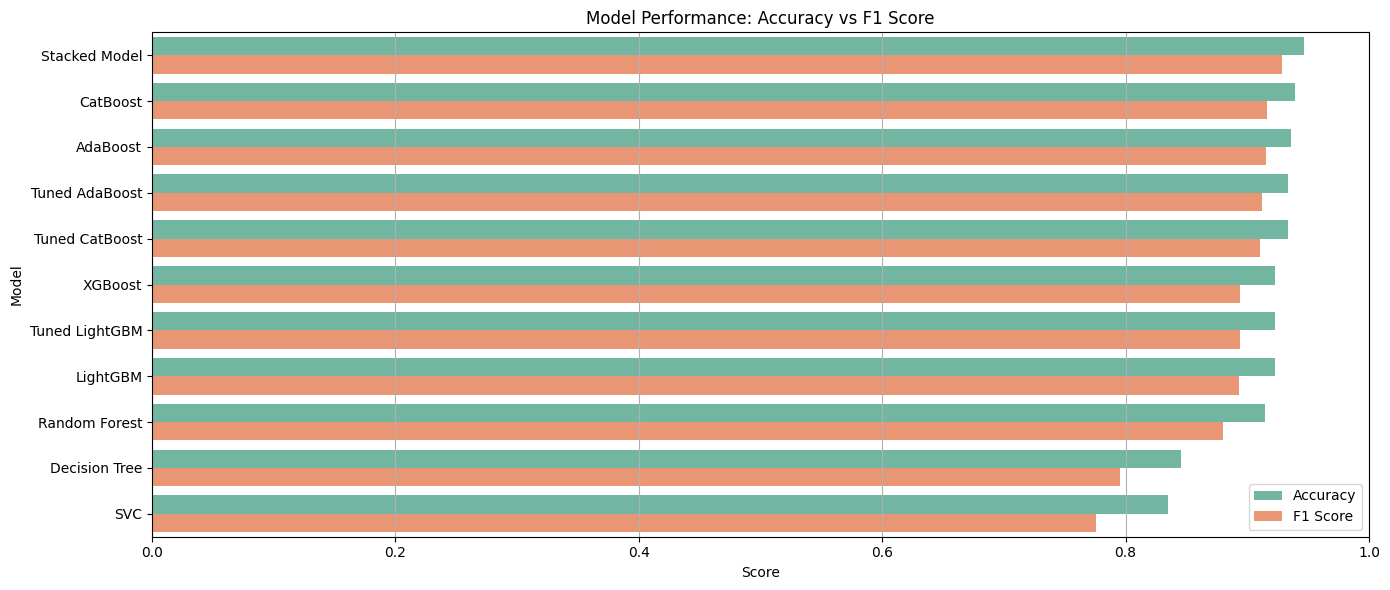

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


melted_df = metrics_df_sorted.melt(id_vars='Model', value_vars=['Accuracy', 'F1 Score'], 
                                    var_name='Metric', value_name='Score')


plt.figure(figsize=(14, 6))
sns.barplot(data=melted_df, x="Score", y="Model", hue="Metric", palette="Set2")
plt.title("Model Performance: Accuracy vs F1 Score")
plt.xlabel("Score")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.legend(loc='lower right')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


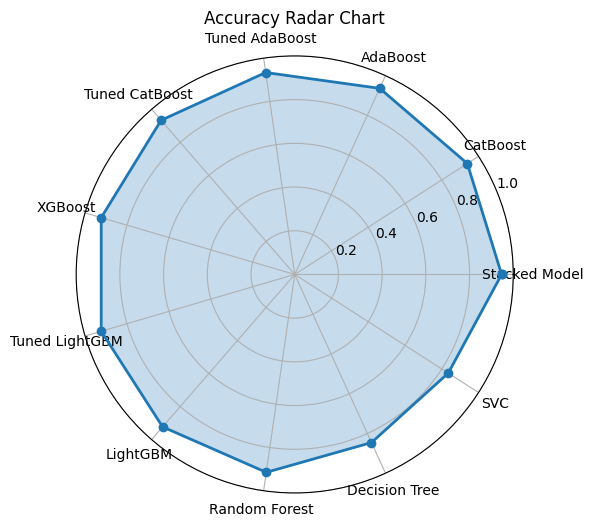

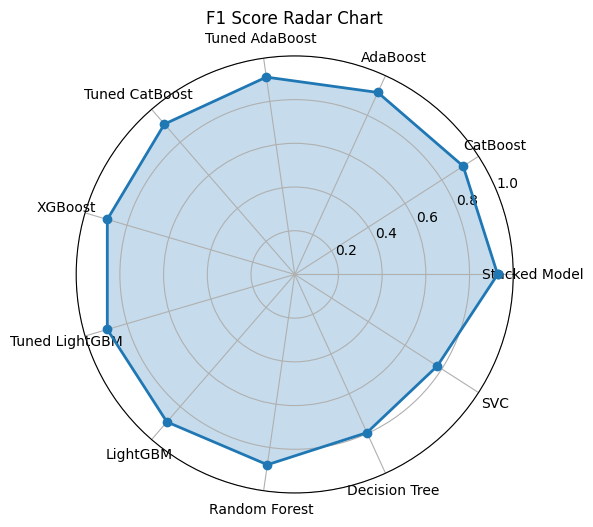

In [ ]:
import numpy as np


def make_radar(values, labels, title):
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    values += values[:1]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, 'o-', linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title(title)
    ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.show()


make_radar(metrics_df_sorted["Accuracy"].tolist(), metrics_df_sorted["Model"].tolist(), "Accuracy Radar Chart")


make_radar(metrics_df_sorted["F1 Score"].tolist(), metrics_df_sorted["Model"].tolist(), "F1 Score Radar Chart")


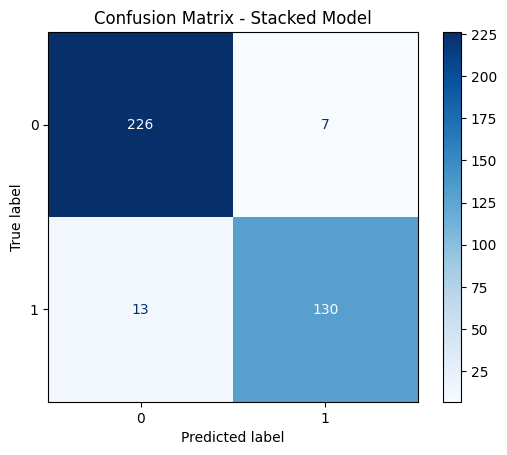

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


cm = confusion_matrix(y_test, y_pred_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Stacked Model")
plt.show()


Final Evaluation Metrics:
| Model          |   Precision |   Recall |   F1 Score |   Accuracy |
|:---------------|------------:|---------:|-----------:|-----------:|
| Stacked Model  |    0.948905 | 0.909091 |   0.928571 |   0.946809 |
| Tuned AdaBoost |    0.934783 | 0.902098 |   0.918149 |   0.93883  |
| CatBoost       |    0.954545 | 0.881119 |   0.916364 |   0.93883  |
| AdaBoost       |    0.921986 | 0.909091 |   0.915493 |   0.93617  |
| Tuned CatBoost |    0.947368 | 0.881119 |   0.913043 |   0.93617  |
| Tuned LightGBM |    0.953488 | 0.86014  |   0.904412 |   0.930851 |
| XGBoost        |    0.938462 | 0.853147 |   0.893773 |   0.922872 |
| LightGBM       |    0.945312 | 0.846154 |   0.892989 |   0.922872 |
| Random Forest  |    0.95122  | 0.818182 |   0.879699 |   0.914894 |
| Decision Tree  |    0.801418 | 0.79021  |   0.795775 |   0.845745 |
| SVC            |    0.804511 | 0.748252 |   0.775362 |   0.835106 |


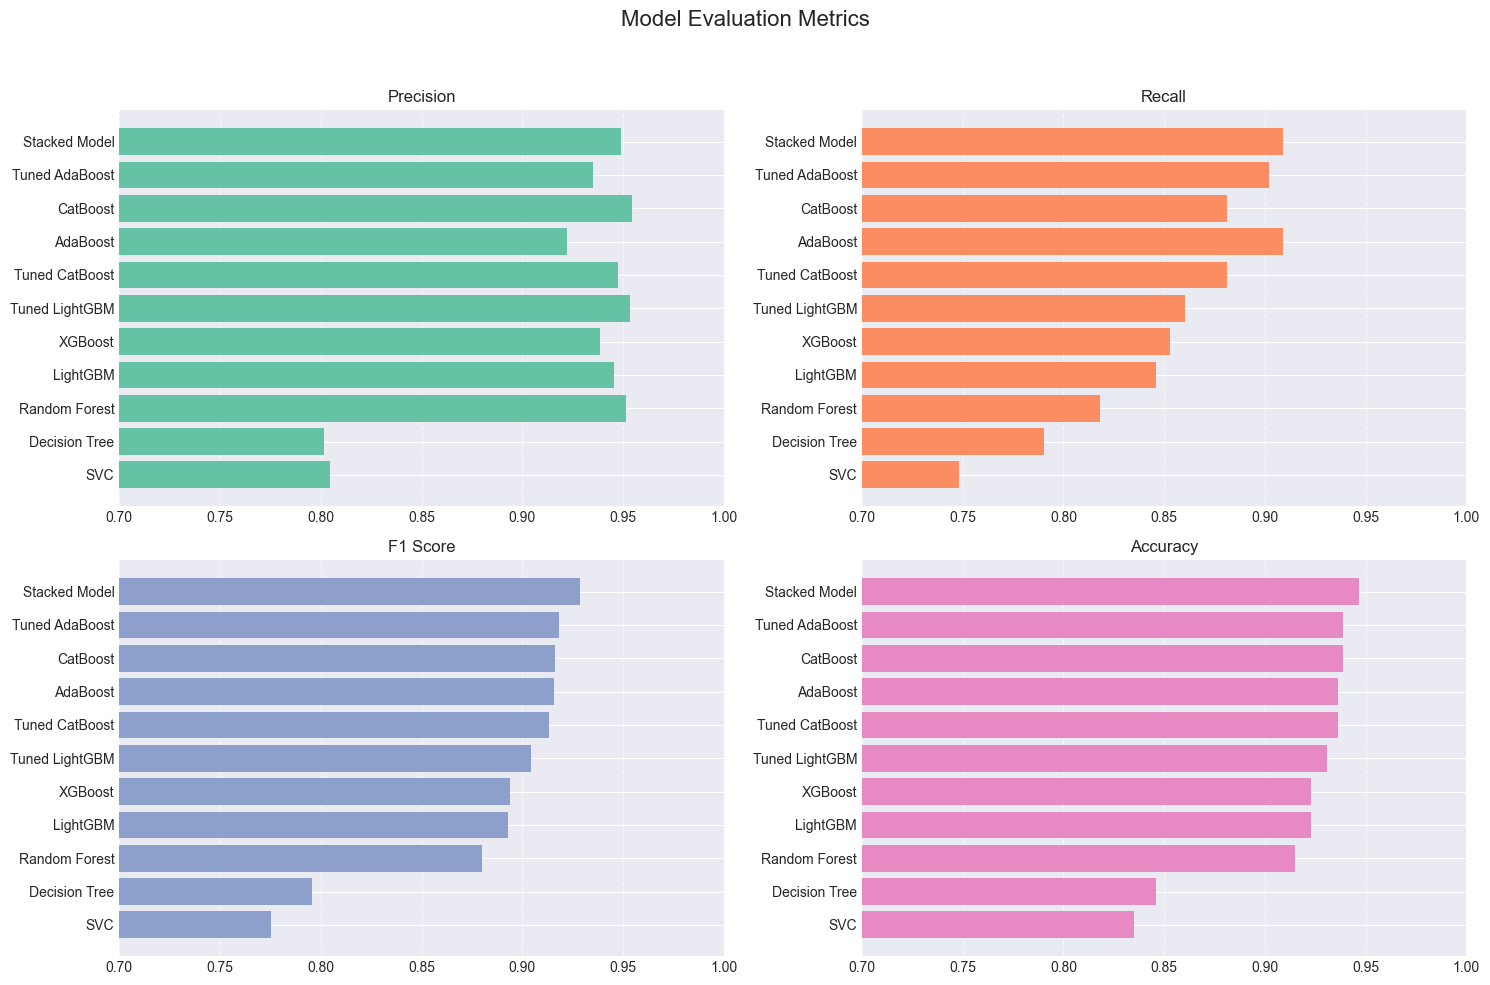

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Data dictionary
data = {
    "Model": [
        "Stacked Model", "Tuned AdaBoost", "CatBoost", "AdaBoost", "Tuned CatBoost",
        "Tuned LightGBM", "XGBoost", "LightGBM", "Random Forest", "Decision Tree", "SVC"
    ],
    "Precision": [0.948905, 0.934783, 0.954545, 0.921986, 0.947368, 0.953488,
                  0.938462, 0.945312, 0.95122, 0.801418, 0.804511],
    "Recall": [0.909091, 0.902098, 0.881119, 0.909091, 0.881119, 0.86014,
               0.853147, 0.846154, 0.818182, 0.79021, 0.748252],
    "F1 Score": [0.928571, 0.918149, 0.916364, 0.915493, 0.913043, 0.904412,
                 0.893773, 0.892989, 0.879699, 0.795775, 0.775362],
    "Accuracy": [0.946809, 0.93883, 0.93883, 0.93617, 0.93617, 0.930851,
                 0.922872, 0.922872, 0.914894, 0.845745, 0.835106],
}

# Create DataFrame
df = pd.DataFrame(data)

# Print as table
print("Final Evaluation Metrics:")
print(df.to_markdown(index=False))

# Set style
plt.style.use('seaborn-darkgrid')
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Model Evaluation Metrics", fontsize=16)

# Plot each metric
metrics = ['Precision', 'Recall', 'F1 Score', 'Accuracy']
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

for i, metric in enumerate(metrics):
    ax = axs[i // 2][i % 2]
    ax.barh(df['Model'], df[metric], color=colors[i])
    ax.set_title(metric)
    ax.set_xlim(0.7, 1.0)
    ax.invert_yaxis()
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


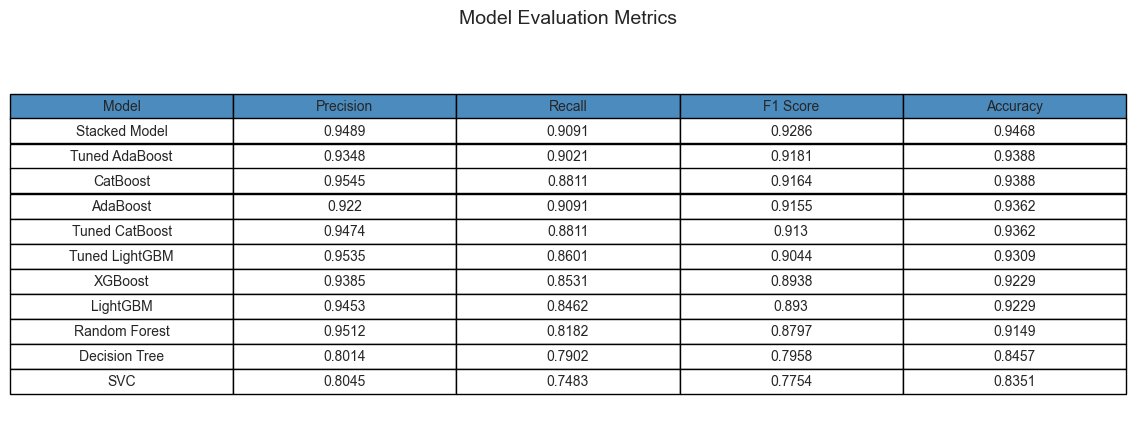

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


data = {
    "Model": [
        "Stacked Model", "Tuned AdaBoost", "CatBoost", "AdaBoost", "Tuned CatBoost",
        "Tuned LightGBM", "XGBoost", "LightGBM", "Random Forest", "Decision Tree", "SVC"
    ],
    "Precision": [0.948905, 0.934783, 0.954545, 0.921986, 0.947368, 0.953488,
                  0.938462, 0.945312, 0.95122, 0.801418, 0.804511],
    "Recall": [0.909091, 0.902098, 0.881119, 0.909091, 0.881119, 0.86014,
               0.853147, 0.846154, 0.818182, 0.79021, 0.748252],
    "F1 Score": [0.928571, 0.918149, 0.916364, 0.915493, 0.913043, 0.904412,
                 0.893773, 0.892989, 0.879699, 0.795775, 0.775362],
    "Accuracy": [0.946809, 0.93883, 0.93883, 0.93617, 0.93617, 0.930851,
                 0.922872, 0.922872, 0.914894, 0.845745, 0.835106],
}


df = pd.DataFrame(data)
df.iloc[:, 1:] = df.iloc[:, 1:].round(4)  # round for display


fig, ax = plt.subplots(figsize=(12, 5))
ax.axis('off')
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center',
    colColours=["#4B8BBE"] * len(df.columns)
)


table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)


plt.title("Model Evaluation Metrics", fontsize=14, pad=20)
plt.savefig("evaluation_metrics_table.png", dpi=300, bbox_inches='tight')
plt.show()
